# Analiza i przetwarzanie dźwięku - Projekt 1


In [1]:
import wave
import numpy as np
import matplotlib.pyplot as plt

In [3]:
with wave.open('recordings/4_10/Znormalizowane/zdanie_1.wav', 'rb') as wav_file:
    channels = wav_file.getnchannels()
    sample_width = wav_file.getsampwidth() # in bytes
    sample_freq = wav_file.getframerate()
    n_samples = wav_file.getnframes()
    signal_wave = wav_file.readframes(n_samples)
time_audio  = n_samples/sample_freq #in seconds
signal_array = np.frombuffer(signal_wave, dtype=np.int16).astype(np.int32)
print(f"{channels=}")
print(f"{time_audio=}")

channels=1
time_audio=2.000453514739229


In [6]:
sample_width

2

In [7]:
n_samples

44110

In [8]:
sample_freq

22050

In [11]:
signal_array.shape

(44110,)

In [101]:
times = np.linspace(0, n_samples/sample_freq, num=n_samples) # time at which each sample is taken

podzial na ramki:
- dlugosc ramek
- zachodzenie


n*N łącznie sampli (jesli sie nie pokrywaja),
mamy n ramek po N sampli (ktore moga i powinny sie pokrywac),
i - pojedynczy sampel,
s_n(i) = amplituda (wartosc w signal_array) w n-tej ramce i-tego sampla


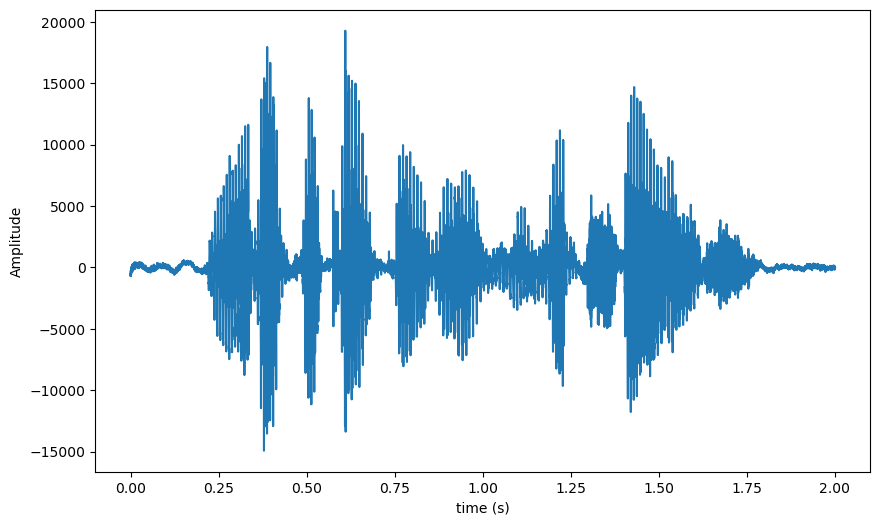

In [92]:
fig = plt.figure(figsize=(10, 6))
plt.plot(times, signal_array)
plt.ylabel("Amplitude")
plt.xlabel("time (s)")
plt.show()

## Frequency Spectrum

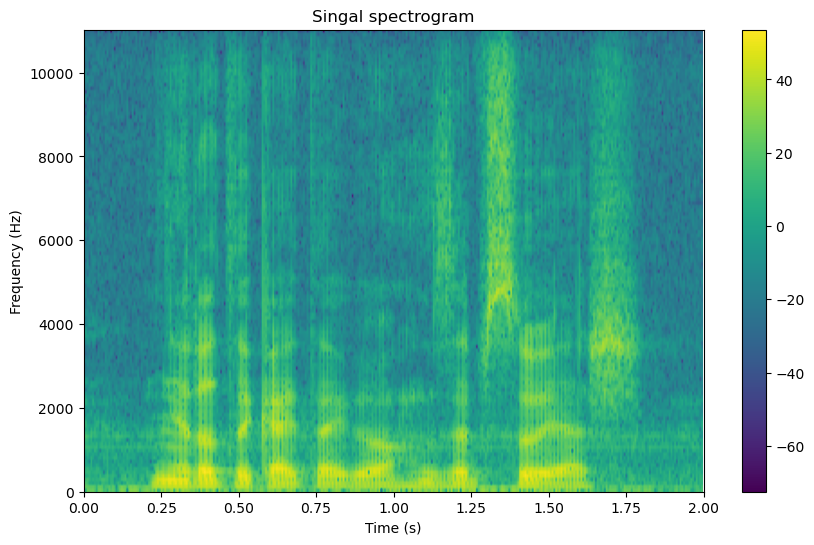

In [93]:
plt.figure(figsize=(10, 6))
plt.specgram(signal_array, Fs=sample_freq)
plt.title('Singal spectrogram')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.xlim(0, time_audio)
plt.colorbar()
plt.show()

## Cechy sygnału audio w dziedzinie czasu na poziomie klipu

###  VSTD - Volume standard deviation normalized by the maximum value in a clip

In [94]:
max_amplitude = np.max(np.abs(signal_array))
vstd = np.std(signal_array)/max_amplitude
print(f"{vstd=}")

avg_amplitude = np.mean(np.abs(signal_array))
print(f"{avg_amplitude=}")


vstd=0.12190501751928569
avg_amplitude=1410.4082747676264


#### VDR - Volume Dynamic Range 

In [99]:
vdr = (np.max(signal_array) - np.min(signal_array))/np.max(signal_array)
print(f"{vdr=}")

vdr=1.7744044838860347
